### Analysis of the Feed Application data 
Explore the data of a feed application.<br>Load data between Feb 20 and Mar 20 2022.

In [1]:
import pandahouse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set(rc={'figure.figsize':(10,8)})

In [2]:
# Load data from csv
df0 = pd.read_csv('Data_Feb20_Mar20.csv')
df0

,user_id,post_id,action,time
0,33099,3070,view,2022-02-27 08:49:58
1,39117,2934,view,2022-02-27 08:49:58
2,39309,3081,view,2022-02-27 08:49:58
3,117248,3125,view,2022-02-27 08:49:58
4,128232,2997,view,2022-02-27 08:49:58
...,...,...,...,...
20141527,140460,4540,view,2022-03-20 21:00:18
20141528,149635,4398,view,2022-03-20 21:00:18
20141529,165865,4520,view,2022-03-20 21:00:18
20141530,7194,4560,like,2022-03-20 21:00:19


In [3]:
# Actions by user
by_user = df0.groupby(['user_id', 'action'], as_index=False).agg({'post_id': 'count'})
by_user

,user_id,action,post_id
0,200,like,45
1,200,view,157
2,201,like,28
3,201,view,81
4,202,like,10
...,...,...,...
242321,168530,view,46
242322,168534,like,6
242323,168534,view,39
242324,168537,like,5


In [20]:
df = by_user.pivot(index='user_id', columns='action', values='post_id').reset_index().rename_axis(None, axis=1)
df

,user_id,like,view
0,200,45.0,157.0
1,201,28.0,81.0
2,202,10.0,27.0
3,203,30.0,126.0
4,204,22.0,84.0
...,...,...,...
121316,168526,6.0,33.0
121317,168527,7.0,29.0
121318,168530,5.0,46.0
121319,168534,6.0,39.0


In [44]:
# Nan to 0
df['like'] = df['like'].fillna(0)

In [52]:
df = df[['user_id', 'like', 'view']].astype(np.int64)

### Likes and Views
Compare the distributions of likes and views.


Histogram:

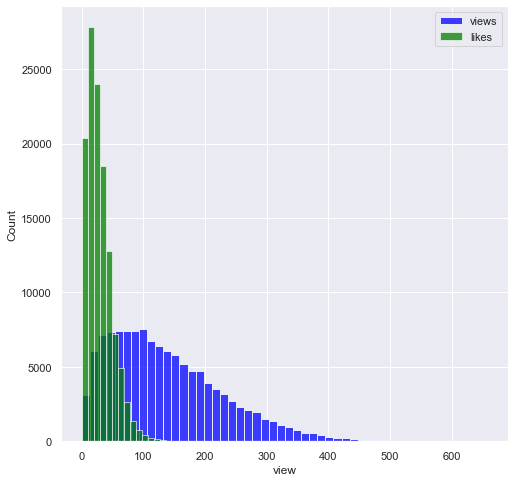

In [58]:
sns.histplot(df, x='view', bins=50, color='blue')
sns.histplot(df, x='like', bins=22, color='green')
plt.legend(labels=['views', 'likes'])

For comparison the values are standardized:

In [59]:
df['z_likes'] = stats.zscore(df.like)
df['z_views'] = stats.zscore(df.view)
df

,user_id,like,view,z_likes,z_views
0,200,45,157,0.793516,0.214306
1,201,28,81,-0.032295,-0.614719
2,202,10,27,-0.906683,-1.203763
3,203,30,126,0.064859,-0.123849
4,204,22,84,-0.323757,-0.581994
...,...,...,...,...,...
121316,168526,6,33,-1.100991,-1.138314
121317,168527,7,29,-1.052414,-1.181946
121318,168530,5,46,-1.149568,-0.996507
121319,168534,6,39,-1.100991,-1.072864


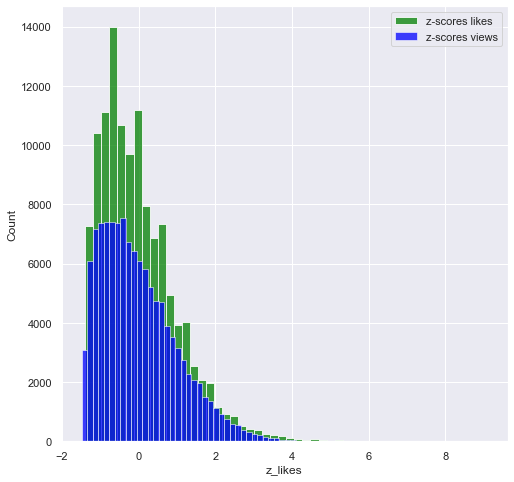

In [61]:
sns.histplot(df, x='z_likes', bins=50, color='green')
sns.histplot(df, x='z_views', bins=50, color='blue')
plt.legend(labels=['z-scores likes', 'z-scores views'])

QQ Plot

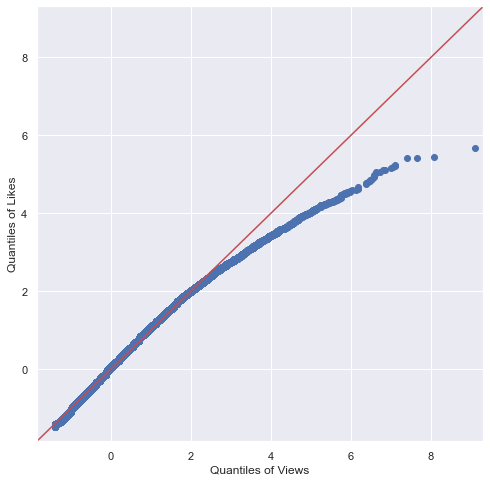

In [64]:
x = df.z_views
y = df.z_likes
pp_x = sm.ProbPlot(x)
pp_y = sm.ProbPlot(y)
qqplot_2samples(pp_x, pp_y, line="45", xlabel='Quantiles of Views', ylabel='Quantiles of Likes')
plt.show()

- The distributions are right-skewed
- For both the peak is near zero
- There is a difference between both distributions

### CTR
Analyze Posts. Get CTR (likes/views) for each post as well as its duration (the number of days it gets "views").

Transform the data:

In [68]:
by_post = df0.groupby(['post_id', 'action'], as_index=False).agg({'user_id': 'count'})

In [85]:
by_post

,post_id,action,user_id
0,2124,like,5
1,2124,view,30
2,2212,like,158
3,2212,view,809
4,2215,like,271
...,...,...,...
4162,4598,view,16
4163,4599,like,335
4164,4599,view,1268
4165,4600,like,818


In [97]:
df1 = by_post.pivot(index='post_id', columns='action', values='user_id').reset_index().rename_axis(None, axis=1)
df1

,post_id,like,view
0,2124,5.0,30.0
1,2212,158.0,809.0
2,2215,271.0,1356.0
3,2235,1567.0,7922.0
4,2243,782.0,4182.0
...,...,...,...
2095,4596,898.0,3965.0
2096,4597,4.0,85.0
2097,4598,1.0,16.0
2098,4599,335.0,1268.0


In [98]:
df1['like'] = df1['like'].fillna(0)

In [108]:
df1 = df1[['post_id', 'like', 'view']].astype(np.int64)

In [110]:
df1 = df1.assign(ctr = df1.like / df1.view)
df1

,post_id,like,view,ctr
0,2124,5,30,0.166667
1,2212,158,809,0.195303
2,2215,271,1356,0.199853
3,2235,1567,7922,0.197804
4,2243,782,4182,0.186992
...,...,...,...,...
2095,4596,898,3965,0.226482
2096,4597,4,85,0.047059
2097,4598,1,16,0.062500
2098,4599,335,1268,0.264196


In [100]:
df0['day'] = df0.time.dt.strftime('%m-%d')
df0

,user_id,post_id,action,time,day
0,33099,3070,view,2022-02-27 08:49:58,02-27
1,39117,2934,view,2022-02-27 08:49:58,02-27
2,39309,3081,view,2022-02-27 08:49:58,02-27
3,117248,3125,view,2022-02-27 08:49:58,02-27
4,128232,2997,view,2022-02-27 08:49:58,02-27
...,...,...,...,...,...
20141527,140460,4540,view,2022-03-20 21:00:18,03-20
20141528,149635,4398,view,2022-03-20 21:00:18,03-20
20141529,165865,4520,view,2022-03-20 21:00:18,03-20
20141530,7194,4560,like,2022-03-20 21:00:19,03-20


In [102]:
df1_days = df0.groupby(['post_id'], as_index=False).agg({'day': 'nunique'}).rename(columns={'day': 'num_days'})

In [112]:
df1_total = df1.merge(df1_days, on='post_id')
df1_total

,post_id,like,view,ctr,num_days
0,2124,5,30,0.166667,1
1,2212,158,809,0.195303,1
2,2215,271,1356,0.199853,1
3,2235,1567,7922,0.197804,3
4,2243,782,4182,0.186992,2
...,...,...,...,...,...
2095,4596,898,3965,0.226482,1
2096,4597,4,85,0.047059,1
2097,4598,1,16,0.062500,1
2098,4599,335,1268,0.264196,1


In [122]:
df1_total.describe()

,post_id,like,view,ctr,num_days
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,3505.548571,1656.020952,7935.184762,0.136312,2.699048
std,637.007644,3019.123733,11684.810042,0.060269,1.372464
min,2124.000000,0.000000,2.000000,0.000000,1.000000
25%,2960.750000,53.000000,618.750000,0.093427,2.000000
50%,3509.500000,377.500000,2980.000000,0.124729,2.000000
75%,4057.250000,1758.500000,10325.500000,0.175640,3.000000
max,4600.000000,26507.000000,89909.000000,0.375000,8.000000


Plot the distributions of CTR and the duration of posts:

<AxesSubplot:xlabel='ctr', ylabel='Count'>

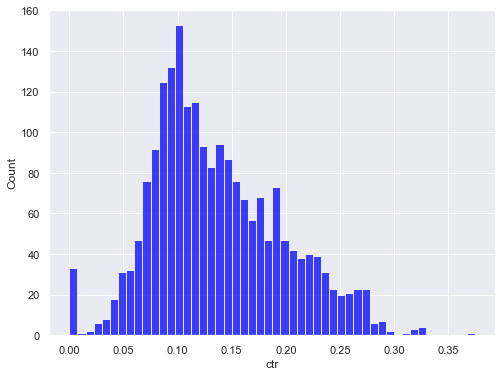

In [118]:
sns.histplot(df1_total, x='ctr', bins=50, color='blue')

<AxesSubplot:xlabel='num_days', ylabel='Count'>

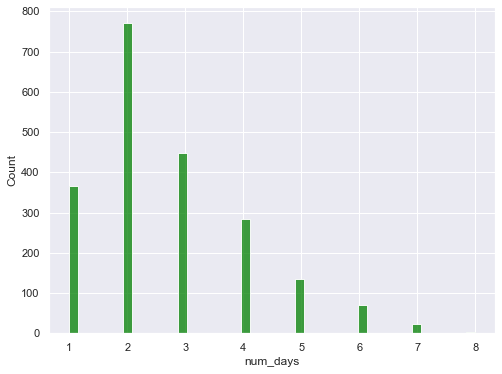

In [119]:
sns.histplot(df1_total, x='num_days', color='green')

In [120]:
df1_total[['like', 'view', 'ctr', 'num_days']].corr()

,like,view,ctr,num_days
like,1.000000,0.989878,0.772645,0.820037
view,0.989878,1.000000,0.815973,0.874044
ctr,0.772645,0.815973,1.000000,0.773010
num_days,0.820037,0.874044,0.773010,1.000000


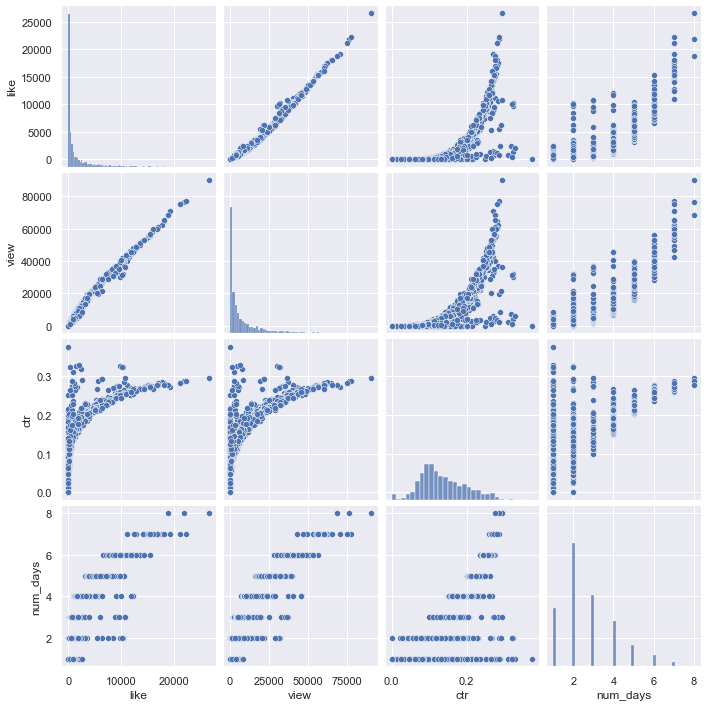

In [121]:
sns.pairplot(df1_total[['like', 'view', 'ctr', 'num_days']])

- CTR distribution is less skewed compared to those of likes and views
- Number of likes and the duration of a post are not linearly dependent
- The average duration of a post is 3 days
- The highest positive correlation is between likes and views

### Hourly activity dynamics
Draw a seasonality plot to explore the overall dynamics.

In [132]:
df0['hour'] = pd.to_datetime(df0.time).dt.to_period('H').dt.to_timestamp()

In [135]:
df0

,user_id,post_id,action,time,day,hour
0,33099,3070,view,2022-02-27 08:49:58,02-27,2022-02-27 08:00:00
1,39117,2934,view,2022-02-27 08:49:58,02-27,2022-02-27 08:00:00
2,39309,3081,view,2022-02-27 08:49:58,02-27,2022-02-27 08:00:00
3,117248,3125,view,2022-02-27 08:49:58,02-27,2022-02-27 08:00:00
4,128232,2997,view,2022-02-27 08:49:58,02-27,2022-02-27 08:00:00
...,...,...,...,...,...,...
20141527,140460,4540,view,2022-03-20 21:00:18,03-20,2022-03-20 21:00:00
20141528,149635,4398,view,2022-03-20 21:00:18,03-20,2022-03-20 21:00:00
20141529,165865,4520,view,2022-03-20 21:00:18,03-20,2022-03-20 21:00:00
20141530,7194,4560,like,2022-03-20 21:00:19,03-20,2022-03-20 21:00:00


In [136]:
# Calculate number of activities by hour
df_hourly = df0.groupby('hour').agg({'action': 'count'})
df_hourly

,action
hour,
2022-02-20 00:00:00,25817
2022-02-20 01:00:00,22189
2022-02-20 02:00:00,16826
2022-02-20 03:00:00,12650
2022-02-20 04:00:00,12518
...,...
2022-03-20 19:00:00,54169
2022-03-20 20:00:00,51446
2022-03-20 21:00:00,50097


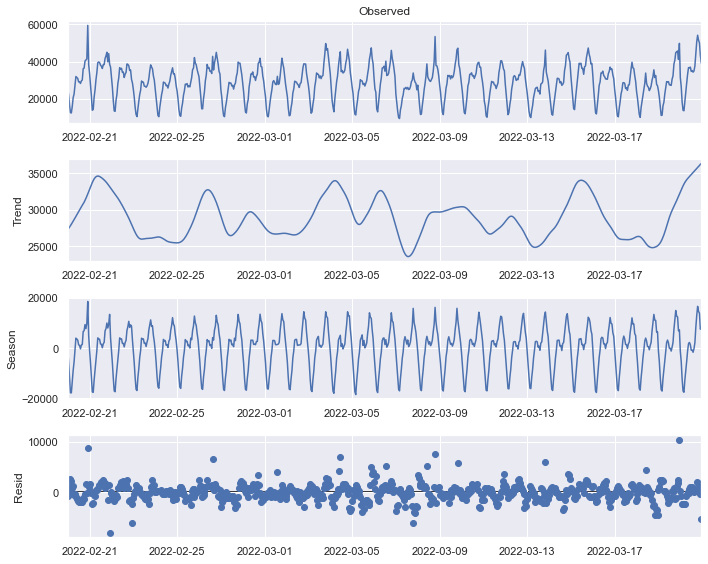

In [150]:
result = STL(df_hourly).fit()

result.plot()
plt.show()

### User activity and Feed posts

Compare distributions of user activity and publishing of feed posts on average during the day.

In [152]:
df0.head(3)

,user_id,post_id,action,time,day,hour
0,33099,3070,view,2022-02-27 08:49:58,02-27,2022-02-27 08:00:00
1,39117,2934,view,2022-02-27 08:49:58,02-27,2022-02-27 08:00:00
2,39309,3081,view,2022-02-27 08:49:58,02-27,2022-02-27 08:00:00


#### User activity

In [171]:
actions_hourly = df0.groupby('hour', as_index=False).agg({'action': 'count'}).rename(columns={'action': 'num_actions'})
actions_hourly

,hour,num_actions
0,2022-02-20 00:00:00,25817
1,2022-02-20 01:00:00,22189
2,2022-02-20 02:00:00,16826
3,2022-02-20 03:00:00,12650
4,2022-02-20 04:00:00,12518
...,...,...
691,2022-03-20 19:00:00,54169
692,2022-03-20 20:00:00,51446
693,2022-03-20 21:00:00,50097
694,2022-03-20 22:00:00,43388


In [172]:
# Extract hour
actions_hourly['hours'] = actions_hourly['hour'].dt.hour

In [173]:
actions_hourly

,hour,num_actions,hours
0,2022-02-20 00:00:00,25817,0
1,2022-02-20 01:00:00,22189,1
2,2022-02-20 02:00:00,16826,2
3,2022-02-20 03:00:00,12650,3
4,2022-02-20 04:00:00,12518,4
...,...,...,...
691,2022-03-20 19:00:00,54169,19
692,2022-03-20 20:00:00,51446,20
693,2022-03-20 21:00:00,50097,21
694,2022-03-20 22:00:00,43388,22


In [175]:
# Average number of actions per specific hour
avg_actions_hourly = actions_hourly.groupby('hours', as_index=False).agg({'num_actions':'mean'}).sort_values(by='hours')
avg_actions_hourly

,hours,num_actions
0,0,27463.034483
1,1,22715.931034
2,2,17148.413793
3,3,12321.137931
4,4,11849.137931
5,5,16701.896552
6,6,20339.620690
7,7,24909.379310
8,8,27868.275862
9,9,32090.862069


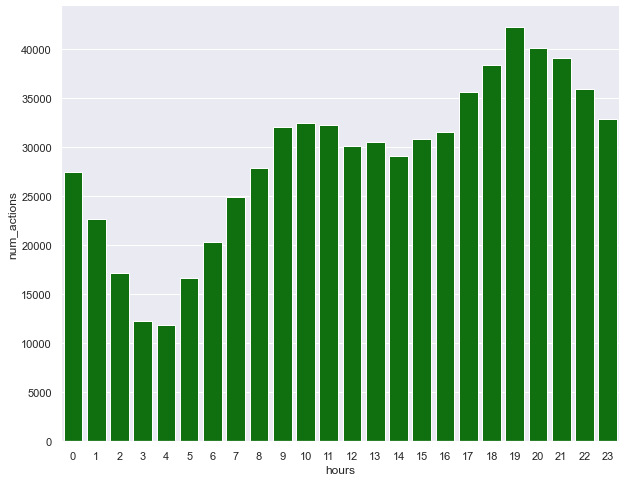

In [176]:
fig, ax = plt.subplots()
ax1 = sns.barplot(data=avg_actions_hourly, x='hours', y='num_actions', color='green')
sns.despine(top=True)

#### Posts

In [156]:
# Posting date
time_posted = df0.sort_values('time').drop_duplicates('post_id')
time_posted

,user_id,post_id,action,time,day,hour
589832,135571,2475,view,2022-02-20 00:00:00,02-20,2022-02-20 00:00:00
589824,14424,2525,view,2022-02-20 00:00:00,02-20,2022-02-20 00:00:00
589825,23479,2557,view,2022-02-20 00:00:00,02-20,2022-02-20 00:00:00
589826,30171,2363,view,2022-02-20 00:00:00,02-20,2022-02-20 00:00:00
589827,111856,2518,view,2022-02-20 00:00:00,02-20,2022-02-20 00:00:00
...,...,...,...,...,...,...
19848176,115546,4597,view,2022-03-20 22:59:40,03-20,2022-03-20 22:00:00
19985060,29787,4536,view,2022-03-20 23:20:02,03-20,2022-03-20 23:00:00
19988302,114845,4565,view,2022-03-20 23:24:35,03-20,2022-03-20 23:00:00
19990088,68050,4598,view,2022-03-20 23:27:31,03-20,2022-03-20 23:00:00


In [157]:
# Number of posts per hour for the whole period
posts_per_hour = time_posted.groupby(['hour', 'day'], as_index=False).agg({'post_id':'count'}).rename(columns={'post_id':'num_posts'}).sort_values(by='hour')
posts_per_hour

,hour,day,num_posts
0,2022-02-20 00:00:00,02-20,154
1,2022-02-20 02:00:00,02-20,1
2,2022-02-20 13:00:00,02-20,1
3,2022-02-20 14:00:00,02-20,1
4,2022-02-20 15:00:00,02-20,3
...,...,...,...
350,2022-03-20 19:00:00,03-20,11
351,2022-03-20 20:00:00,03-20,8
352,2022-03-20 21:00:00,03-20,5
353,2022-03-20 22:00:00,03-20,5


In [158]:
# Average per specific hour
posts_per_hour['hours'] = posts_per_hour['hour'].dt.hour
posts_per_hour

,hour,day,num_posts,hours
0,2022-02-20 00:00:00,02-20,154,0
1,2022-02-20 02:00:00,02-20,1,2
2,2022-02-20 13:00:00,02-20,1,13
3,2022-02-20 14:00:00,02-20,1,14
4,2022-02-20 15:00:00,02-20,3,15
...,...,...,...,...
350,2022-03-20 19:00:00,03-20,11,19
351,2022-03-20 20:00:00,03-20,8,20
352,2022-03-20 21:00:00,03-20,5,21
353,2022-03-20 22:00:00,03-20,5,22


In [159]:
# Overall average
avg_posts_per_hour = posts_per_hour.groupby('hours', as_index=False).agg({'num_posts':'mean'}).sort_values(by='hours')
avg_posts_per_hour

,hours,num_posts
0,0,8.541667
1,1,1.411765
2,2,1.000000
3,11,1.000000
4,12,1.000000
5,13,1.500000
6,14,2.333333
7,15,2.192308
8,16,5.037037
9,17,5.862069


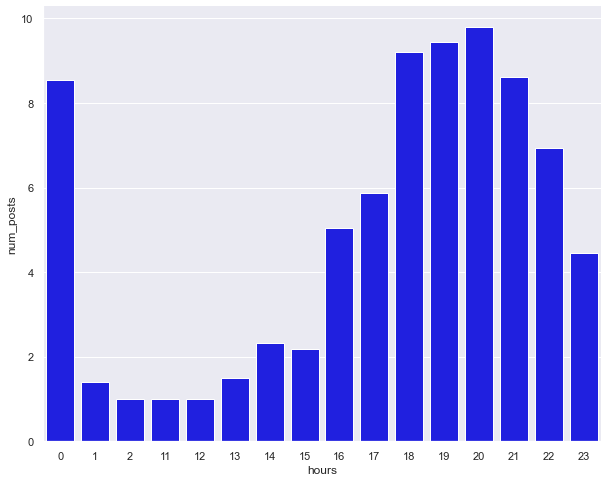

In [165]:
fig, ax = plt.subplots()
ax = sns.barplot(data=avg_posts_per_hour, x='hours', y='num_posts', color='blue')
sns.despine(top=True)

- Most of the posts are published at 8 PM
- Posts are not published every hour
- Users are least active at 4 AM
- Peaks of activity differ from the peak of post publishing